In [1]:
import sys, os

import numpy as np
from umap import UMAP
import time
import torch
import matplotlib.pyplot as plt
import pandas as pd  
import scanpy as sc
import scipy.sparse as sps
import scipy.io as sio
# import scipy.sparse as sp
from os.path import join

import scmomat 

plt.rcParams["font.size"] = 10

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/umap_learn-0.5.3-py3.8.egg/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/umap_learn-0.5.3-py3.8.egg/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/yanx

## Step 1: Load dataset

In [2]:
data_dir = "/home/sda1/yanxh/data/Seurat_demo_data/pbmc_multiome"
out_dir = '/home/yanxh/gitrepo/multi-omics-matching/neurips2021_multimodal_topmethods-main/output/pretrain/scmomat/pbmc_mult'

In [3]:
print('Reading `mtx` files...')
rna_count_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'rna_mat_count.mtx')).T)
atac_count_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'atac_mat_count.mtx')).T)

rna_names = pd.read_csv(join(data_dir, 'gene_names.csv'))['x'].to_numpy()
atac_names = pd.read_csv(join(data_dir, 'atac_names.csv'))['x'].to_numpy()

cell_names = pd.read_csv(join(data_dir, 'cell_names.csv'))['x'].to_numpy()
meta_data = pd.read_csv(join(data_dir, 'metadata.csv'), index_col=0)

rna_count_mat.shape, atac_count_mat.shape

Reading `mtx` files...


((10411, 36601), (10411, 106086))

In [4]:
train_idx = pd.read_csv(join(data_dir, 'train_idx.csv'))['0'].to_numpy()
test_idx  = pd.read_csv(join(data_dir, 'test_idx.csv'))['0'].to_numpy()

train_idx.size, test_idx.size

(6940, 3471)

In [5]:
# df_r2g = pd.read_csv(os.path.join(out_dir, 'GxR.csv'))
# df_r2g.head()

## down scale data

In [6]:
ad_mult_rna = sc.AnnData(rna_count_mat[train_idx])
ad_mult_rna.var_names = rna_names
sc.pp.highly_variable_genes(ad_mult_rna, flavor='seurat_v3', n_top_genes=5000)
hvg_idx = np.where(ad_mult_rna.var.highly_variable)[0]
hvg_names = rna_names[hvg_idx]

# variable peak, follow CLUE
hvp_idx = np.argsort(atac_count_mat[train_idx].sum(axis=0).A1)[-20000:]
hvp_names = atac_names[hvp_idx]

### format data

In [7]:
n_batches = 3

genes = hvg_names
regions = hvp_names
feats_name = {"rna": genes, "atac": regions}

barcodes = [cell_names[train_idx], cell_names[test_idx], cell_names[test_idx]]
labels = [meta_data.loc[_, 'seurat_annotations'].to_list() for _ in barcodes]
mods = [['multiome']*train_idx.size, ['rna']*test_idx.size, ['atac']*test_idx.size]
batches = [['batch1']*train_idx.size, ['batch1']*test_idx.size, ['batch1']*test_idx.size]

In [8]:
# READ IN THE COUNT MATRICES
# scRNA-seq of batch 1
counts_rna1 = rna_count_mat[train_idx][:, hvg_idx]
counts_rna1 = scmomat.preprocess(counts_rna1.A, modality = "RNA", log = False)
counts_rna2 = rna_count_mat[test_idx][:, hvg_idx]
counts_rna2 = scmomat.preprocess(counts_rna2.A, modality = "RNA", log = False)
counts_rnas = [counts_rna1, counts_rna2, None]

# scATAC-seq of batch 1
counts_atac1 = atac_count_mat[train_idx][:, hvp_idx]
counts_atac1 = scmomat.preprocess(counts_atac1.A, modality = "ATAC")
counts_atac3 = atac_count_mat[test_idx][:, hvp_idx]
counts_atac3 = scmomat.preprocess(counts_atac3.A, modality = "ATAC")
counts_atacs = [counts_atac1, None, counts_atac3]

In [9]:
### build GxR matrix from csv 
# r2g_mat = np.zeros((hvp_idx.size, hvg_idx.size), dtype='float32')
# peak_intersected_idx = (df_r2g.peak.isin(hvp_names))
# gene_intersected_idx = (df_r2g['gene.name'].isin(hvg_names))
# valid_r2g_idx = (peak_intersected_idx & gene_intersected_idx)
# df_valid_r2g = df_r2g.loc[valid_r2g_idx]

# for _, row in df_valid_r2g.iterrows():
#     peaki = np.where(row.peak == hvp_names)[0]
#     genej = np.where(row['gene.name'] == hvg_names)[0]
#     r2g_mat[peaki, genej] = 1

In [10]:
# CALCULATE THE PSEUDO-COUNT MATRIX
# Calculate the pseudo-scRNA-seq matrix of batch 3
# counts_rnas[2] = counts_atacs[2] @ r2g_mat
# # Binarize
# counts_rnas[2] = (counts_rnas[2]!=0).astype(int)

# CREATE THE COUNTS OBJECT
counts = {"feats_name": feats_name, "nbatches": n_batches, "rna":counts_rnas, "atac": counts_atacs}

## Step 2: training scMoMaT
The hyper-parameter includes `lamb` for weight lambda in the objective function, `K` for the number of latent dimensions. The default parameter (`lamb = 0.001`, `K = 30`) works for most of the real datasets.

Input sanity check...
Finished.
Epoch 1, Validating Loss: 402.8346
	 loss reconstruction: 0.40247
	 loss regularization: 0.36000
Epoch 1000, Validating Loss: 318.5109
	 loss reconstruction: 0.31850
	 loss regularization: 0.00899
Epoch 2000, Validating Loss: 317.2576
	 loss reconstruction: 0.31725
	 loss regularization: 0.01122
Epoch 3000, Validating Loss: 316.7084
	 loss reconstruction: 0.31670
	 loss regularization: 0.00447
Epoch 4000, Validating Loss: 316.4128
	 loss reconstruction: 0.31641
	 loss regularization: 0.00484
running time: 116.87118935585022


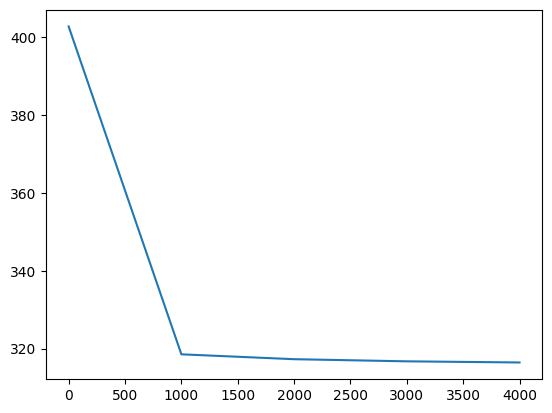

In [11]:
#------------------------------------------------------------------------------------------------------------------------------------
# NOTE: Number of latent dimensions, key hyper-parameter, 20~30 works for most of the cases.
K = 30
#------------------------------------------------------------------------------------------------------------------------------------
# NOTE: Here we list other parameters in the function for illustration purpose, most of these parameters are set as default value.
# weight on regularization term, default value
lamb = 0.001 
# number of total iterations, default value
T = 4000
# print the result after each ``interval'' iterations, default value
interval = 1000
# batch size for each iteraction, default value
batch_size = 0.1
# learning rate, default value
lr = 1e-2
# random seed, default value
seed = 0
# running device, can be CPU or GPU
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

#------------------------------------------------------------------------------------------------------------------------------------

start_time = time.time()
model = scmomat.scmomat_model(counts = counts, K = K, batch_size = batch_size, interval = interval, lr = lr, lamb = lamb, seed = seed, device = device)
losses = model.train_func(T = T)
end_time = time.time()
print("running time: " + str(end_time - start_time))

# Plot loss function
x = np.linspace(0, T, int(T/interval)+1)
plt.plot(x, losses)

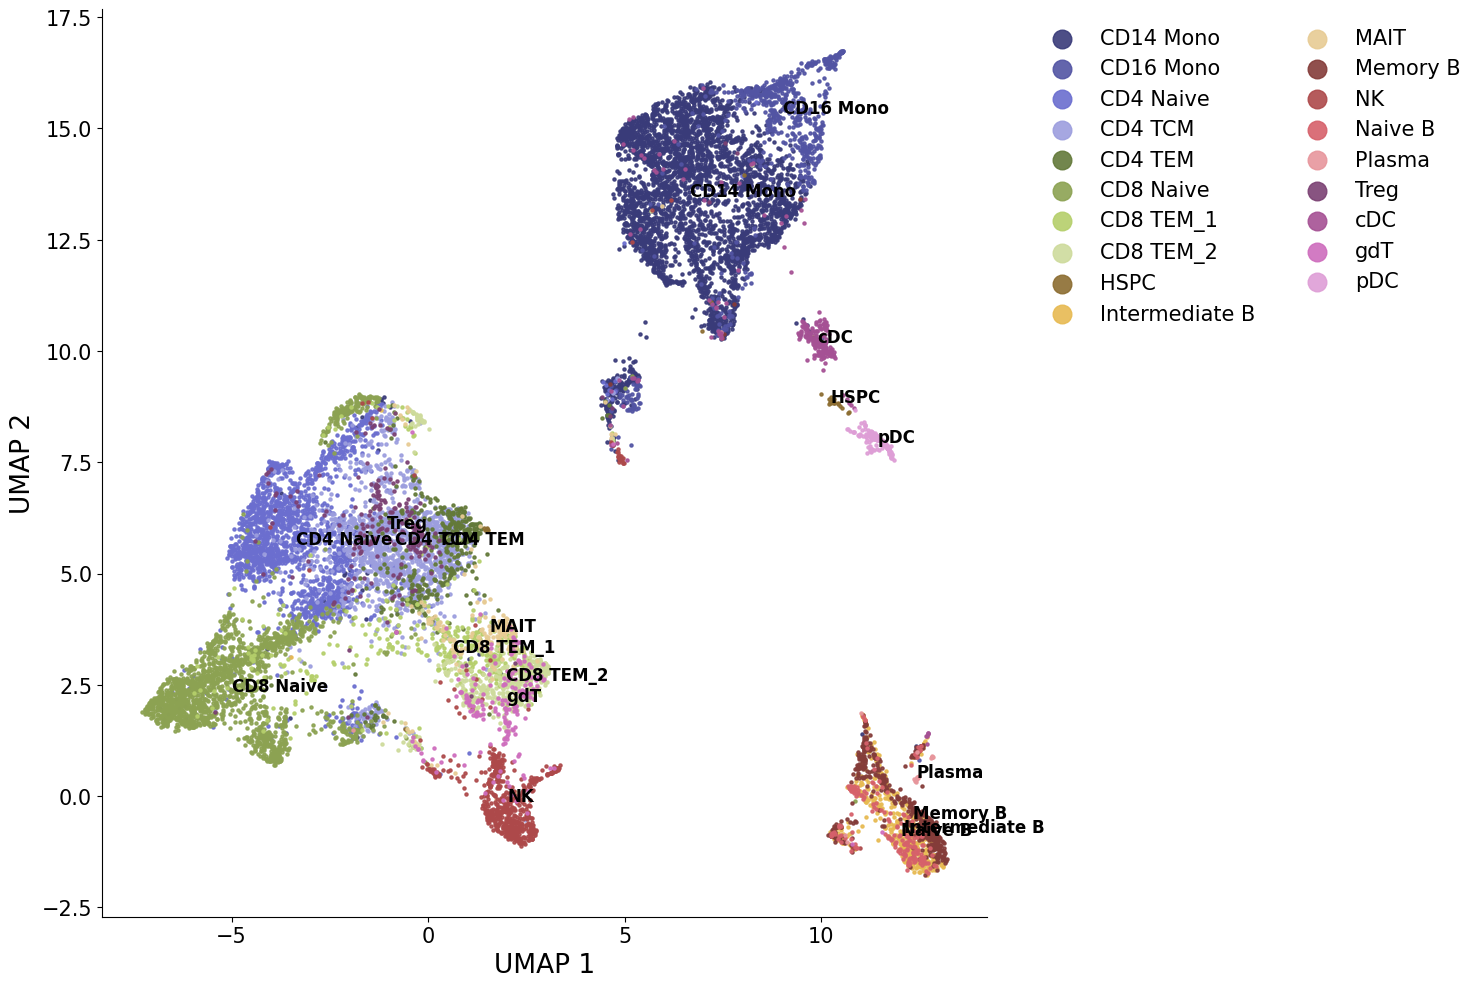

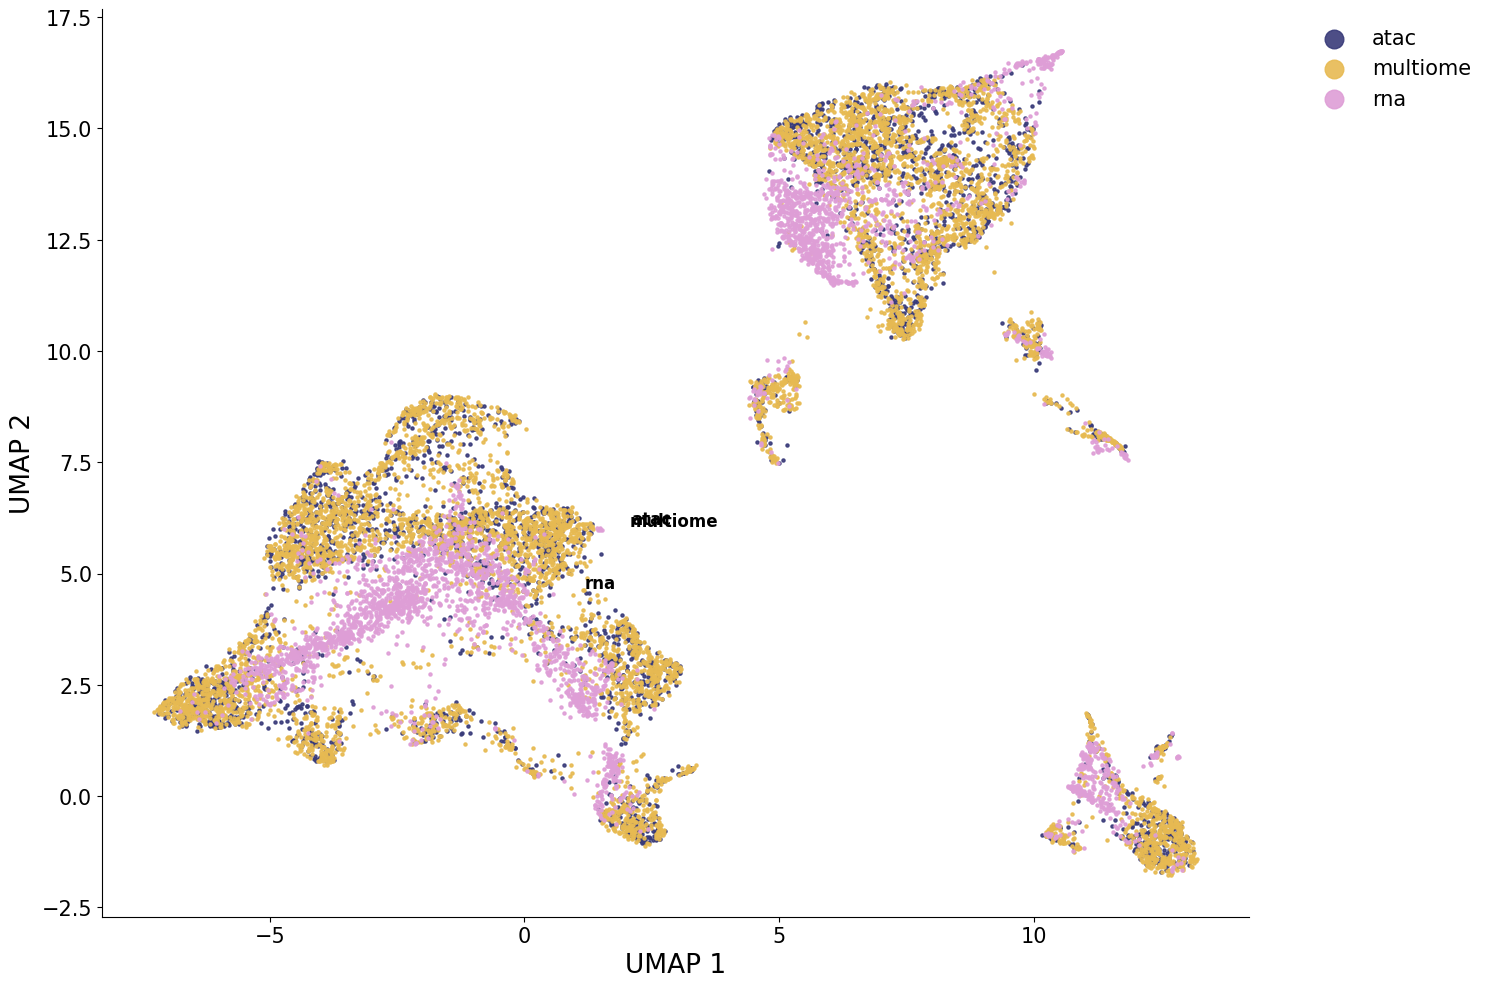

In [12]:
# read in the ground truth labels
# NOTE: Plot the result before post-processing
umap_op = UMAP(n_components = 2, n_neighbors = 30, min_dist = 0.2, random_state = 0) 
zs = model.extract_cell_factors()
x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))

scmomat.plot_latent(x_umap, annos = np.concatenate(labels), 
                    mode = "joint", save = None, 
                    figsize = (15,10), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = True)
scmomat.plot_latent(x_umap, annos = np.concatenate(mods), 
                    mode = "joint", save = None, 
                    figsize = (15,10), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = True)

## Step 3: Post-processing
The hyper-parameter includes `n_neighbors` and `r`. Use `r = None` unless the cell type composition is highly unmatched. In the unmatched case, `r` can be set between `0.5` and `1`, where a smaller values means lower batch correction. `n_neighbors` should be adjusted according to the total number of batches, usually `5-15` for each batch would be enough.

In [13]:
zs = model.extract_cell_factors()

# n_neighbors = 100
# r = None
# resolution = 0.9
# knn_indices, knn_dists = scmomat.calc_post_graph(zs, n_neighbors, njobs = 8, r = r)
# # labels_leiden = scmomat.leiden_cluster(X = None, knn_indices = knn_indices, knn_dists = knn_dists, resolution = resolution)
# x_umap = scmomat.calc_umap_embedding(
#     knn_indices = knn_indices, knn_dists = knn_dists, 
#     n_components = 2, n_neighbors = n_neighbors, min_dist = 0.20, random_state = 0)

# scmomat.plot_latent(x_umap, 
#                     annos=np.concatenate(mods),
#                     mode = "joint", save = None,\
#                       figsize = (10,7), axis_label = "UMAP", 
#                     markerscale = 6, s = 5, label_inplace = False, alpha = 0.7)

# scmomat.plot_latent(x_umap, 
#                     annos=np.concatenate(labels),
#                     mode = "joint", save = None,\
#                       figsize = (10,7), axis_label = "UMAP", 
#                     markerscale = 6, s = 5, label_inplace = False, alpha = 0.7)



# save results

In [14]:
ad_mosaic = sc.AnnData(np.vstack(zs), obsm={"X_emb":np.vstack(zs)})
ad_mosaic.obs['batch'] = np.hstack(batches)
ad_mosaic.obs['mod']   = np.hstack(mods)
ad_mosaic.obs['cell_type'] = np.hstack(labels)
# ad_mosaic.obsm['X_umap'] = x_umap

# ad_mosaic.obsp['connectivities'] = scmomat.utils._compute_connectivities_umap(
#     knn_indices = knn_indices, knn_dists = knn_dists, 
#     n_neighbors = 15, set_op_mix_ratio=1.0, local_connectivity=1.0
# )
# ad_mosaic.uns['neighbors'] = {'connectivities_key':'connectivities'}

In [15]:
import sys
sys.path.insert(0, '.')

from evaluation import eval_mosaic, eval_specific_mod, eval_bridge, print_results, eval_asw, eval_lisi, eval_clustering

def get_umap(adata, use_rep='X_emb_shr'):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    return adata

### before harmony

In [17]:
# mosaic eval
r = eval_mosaic(ad_mosaic, label_key='cell_type', batch_keys=['mod'], use_lisi=True, use_rep='X_emb', use_neighbors=False)  # mod-lisi = batch_lisi

cell_type_LISI=0.98158
mod_LISI=0.41469
Compute neighbors using X_emb
GC=0.95443
NMI=0.64753
ARI=0.58326


In [18]:
# nmi, ari using nmi search
nmi, ari = eval_clustering(
    ad_mosaic, label_key='cell_type', cluster_key='cluster', resolutions=None, use_rep='X_emb', use_neighbors=True,
    use='nmi', nmi_method='arithmetic')
nmi, ari

(0.6505796170559296, 0.5162499322252907)

In [19]:
ad_gex_test = sc.AnnData(zs[1], obsm={"X_emb":zs[1]})
ad_atac_test = sc.AnnData(zs[2], obsm={"X_emb":zs[2]})

ad_gex_test.obs['cell_type'] = labels[1]; ad_gex_test.obs['batch'] = batches[1]; 
ad_atac_test.obs['cell_type'] = labels[2]; ad_atac_test.obs['batch'] = batches[2]; 

r = eval_bridge(
    ad_gex_test, ad_atac_test,
    label_key='cell_type',
    batch_key='batch',
    use_rep='X_emb',
    use_acc=False
)

FOSCTTM=0.09399
Match_score=0.01219


### after harmony

In [16]:
from preprocessing import harmony

ad_mosaic_df = pd.DataFrame(ad_mosaic.obsm['X_emb'], index=ad_mosaic.obs_names)
ad_mosaic_df['batch'] = ad_mosaic.obs['mod'].to_numpy()
ad_mosaic.obsm['X_emb_harmony'] = harmony([ad_mosaic_df])[0]

r = eval_mosaic(ad_mosaic, label_key='cell_type', batch_keys=['mod'], use_lisi=True, use_rep='X_emb_harmony', use_neighbors=False) 

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
Reach convergence after 6 iteration(s).
cell_type_LISI=0.98119
mod_LISI=0.59910
Compute neighbors using X_emb_harmony
GC=0.93885
NMI=0.68579
ARI=0.65169


In [22]:
# nmi, ari using nmi search
nmi, ari = eval_clustering(
    ad_mosaic, label_key='cell_type', cluster_key='cluster', resolutions=None, use_rep='X_emb_harmony', use_neighbors=True,
    use='nmi', nmi_method='arithmetic')
nmi, ari

(0.6857922682704164, 0.6516921351125096)

In [31]:
z_har = ad_mosaic.obsm['X_emb_harmony']
z_har_b2 = z_har[len(zs[0]):(len(zs[0]) + len(zs[1]))]
z_har_b3 = z_har[-len(zs[2]):]
ad_gex_test = sc.AnnData(z_har_b2, obsm={"X_emb_harmony":z_har_b2})
ad_atac_test = sc.AnnData(z_har_b3, obsm={"X_emb_harmony":z_har_b3})

ad_gex_test.obs['cell_type'] = labels[1]; ad_gex_test.obs['batch'] = batches[1]; 
ad_atac_test.obs['cell_type'] = labels[2]; ad_atac_test.obs['batch'] = batches[2]; 

r = eval_bridge(
    ad_gex_test, ad_atac_test,
    label_key='cell_type',
    batch_key='batch',
    use_rep='X_emb_harmony',
    use_acc=False
)

FOSCTTM=0.08775
Match_score=0.01568


# Vis

In [17]:
def get_umap(adata, use_rep='X_emb_shr', add_key=None):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    
    add_key = 'X_umap' if add_key is None else add_key
    adata.obsm[add_key] = adata.obsm['X_umap']
    return adata

def save_umap(adata, use_rep, colors, is_title='', legend_loc=None, save_dir=None, prefix_name=None):
    for c in colors:
        sc.pl.embedding(adata, basis=use_rep, color=[c], legend_fontsize=4, legend_loc=legend_loc,
              frameon=False, legend_fontoutline=2, show=False, title=is_title) # cmap=reds, vmin=0.00001, 
        plt.savefig(f"{save_dir}/{prefix_name}_{c}_legend={legend_loc}.jpg", bbox_inches="tight", dpi=300)

In [18]:
modD = {'atac':'other', 'multiome':'multiome', 'rna':'gex'}
ad_mosaic.obs['mod2'] = [modD[_] for _ in ad_mosaic.obs['mod']]
# ad_mosaic.obs['mod-batch2'] = ad_mosaic.obs['mod2'].astype('str') + '-' + ad_mosaic.obs.batch.astype('str')

In [19]:
ad_mosaic = get_umap(ad_mosaic, use_rep='X_emb', add_key='umap_be')
ad_mosaic = get_umap(ad_mosaic, use_rep='X_emb_harmony', add_key='umap_af')

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


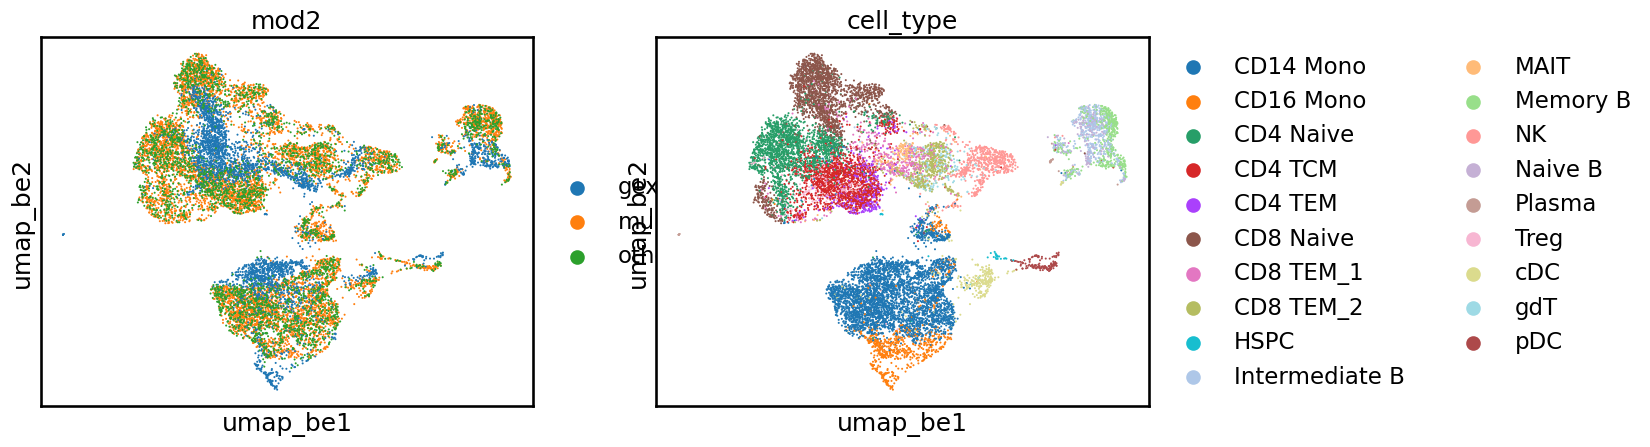

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


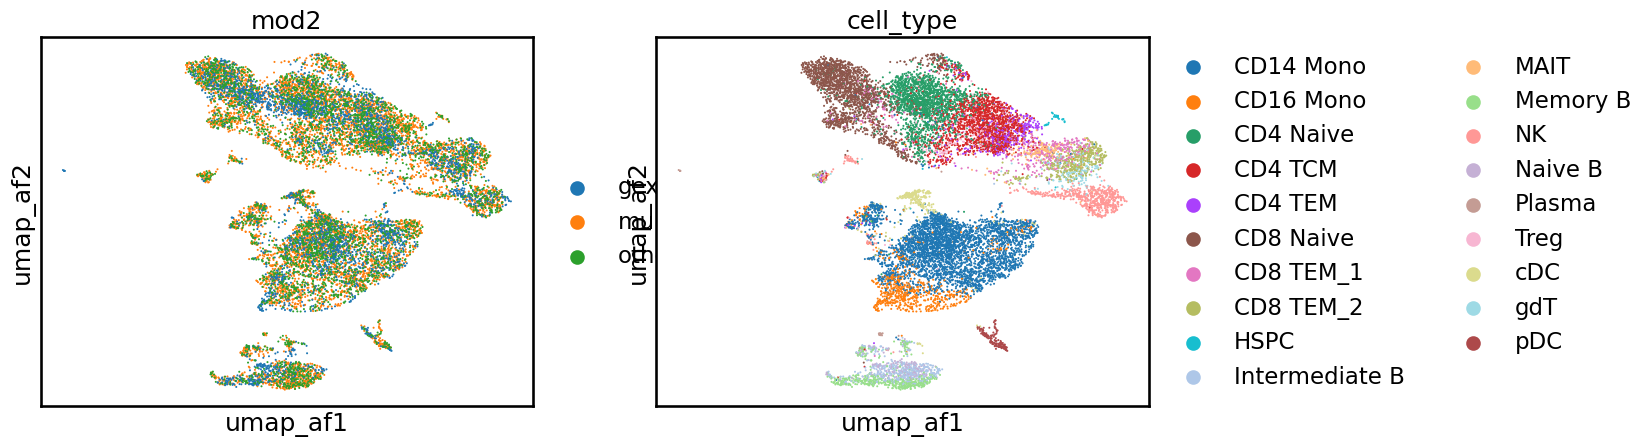

In [20]:
sc.pl.embedding(ad_mosaic, basis='umap_be', color=['mod2', 'cell_type'])
sc.pl.embedding(ad_mosaic, basis='umap_af', color=['mod2', 'cell_type'])

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


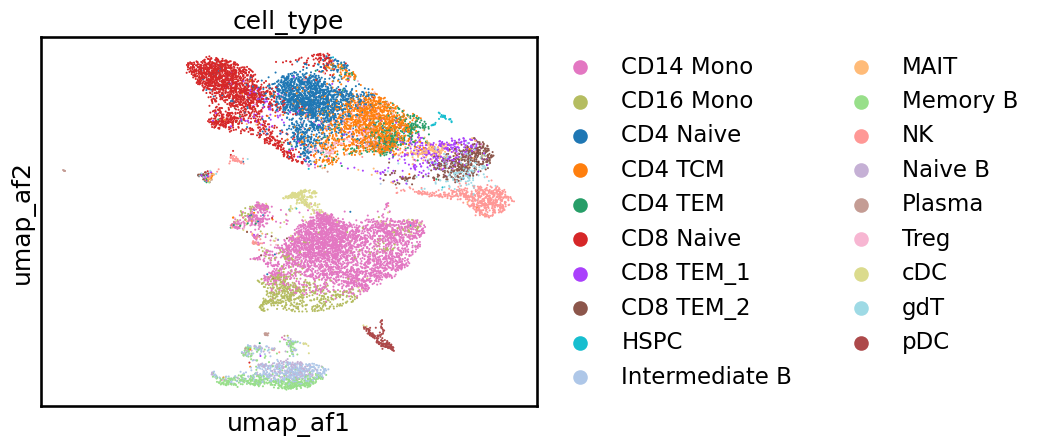

In [21]:
import json
with open('/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec1/umap/pbmc-mult_type_color_dict.json', 'r') as json_file:
    type_color_dict = json.load(json_file)
    
ad_mosaic.uns['cell_type_colors'] = [type_color_dict[_] for _ in ad_mosaic.obs.cell_type.cat.categories]
sc.pl.embedding(ad_mosaic, basis='umap_af', color=['cell_type'])

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages

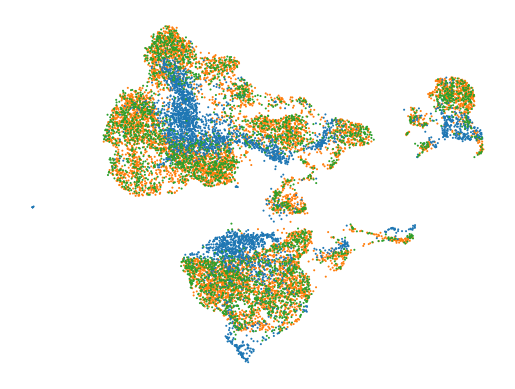

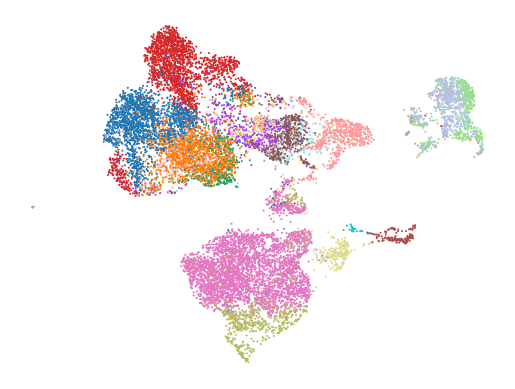

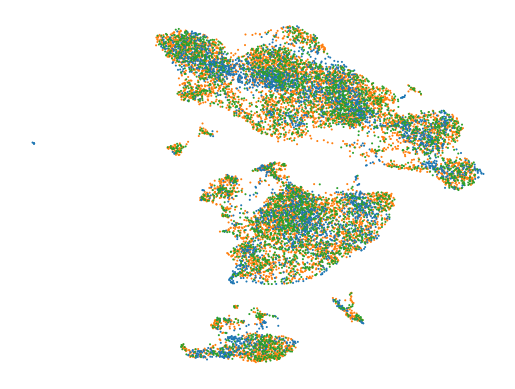

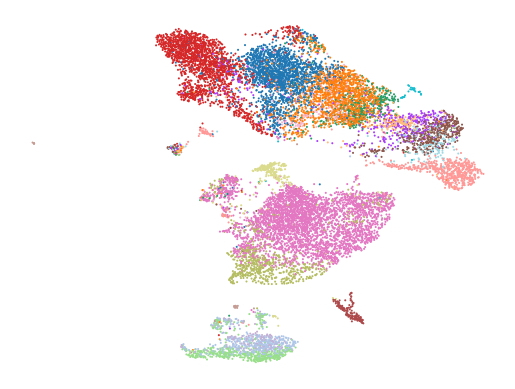

In [22]:
umap_save_dir = '/home/sda1/yanxh/outputs/umap_plots'

save_umap(ad_mosaic, 'umap_be', ['mod2', 'cell_type'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec1/umap', 
          prefix_name='scMoMaT_case1_pbmc-mult')

save_umap(ad_mosaic, 'umap_af', ['mod2', 'cell_type'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec1/umap', 
          prefix_name='scMoMaT-harmony_case1_pbmc-mult')

In [28]:
np.save(join(umap_save_dir, 'scMoMaT_case1_pbmc-mult_umap.npy'), ad_mosaic.obsm['umap_be'])
np.save(join(umap_save_dir, 'scMoMaT-harmony_case1_pbmc-mult_umap.npy'), ad_mosaic.obsm['umap_af'])

In [29]:
1

1

In [30]:
1

1